## Loading packages

In [1]:
install.packages("plotly", repos="http://cran.rstudio.com/")
install.packages("doParallel", repos="http://cran.rstudio.com/")
install.packages("caret", repos="http://cran.rstudio.com/")
install.packages("randomForest", repos="http://cran.rstudio.com/")
install.packages("lubridate", repos="http://cran.rstudio.com/")
install.packages('e1071', dependencies=TRUE,repos="http://cran.rstudio.com/" )
install.packages('gbm', dependencies=TRUE,repos="http://cran.rstudio.com/" )

package 'plotly' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\data science\AppData\Local\Temp\RtmpofUGq1\downloaded_packages
package 'doParallel' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\data science\AppData\Local\Temp\RtmpofUGq1\downloaded_packages
package 'caret' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\data science\AppData\Local\Temp\RtmpofUGq1\downloaded_packages
package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\data science\AppData\Local\Temp\RtmpofUGq1\downloaded_packages
package 'lubridate' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\data science\AppData\Local\Temp\RtmpofUGq1\downloaded_packages
package 'e1071' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\data science\AppData

In [2]:
library(plotly)

Loading required package: ggplot2

Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:graphics':

    layout



## Loading data

In [3]:
allgames <- data.frame(read.csv("bundesliga ges.csv", sep=";"))
# Source: http://www.football-data.co.uk/data.php
# http://api.football-data.org/documentation
# https://github.com/openfootball/de-deutschland/tree/master/2015-16
# https://de.wikipedia.org/wiki/Fu%C3%9Fball-Bundesliga_2015/16
# http://www.bundesliga.de/de/liga/tabelle/

In [4]:
str(allgames)

'data.frame':	1197 obs. of  20 variables:
 $ Match_Date           : Factor w/ 370 levels "01.02.2013","01.02.2014",..: 279 279 263 263 263 263 263 263 249 184 ...
 $ HomeTeam             : Factor w/ 24 levels " FSV MAINZ 05",..: 9 6 12 19 11 13 22 23 17 7 ...
 $ AwayTeam             : Factor w/ 24 levels " FSV MAINZ 05",..: 1 3 2 5 18 4 7 10 24 17 ...
 $ Home_Goals           : num  2 3 4 0 2 2 0 0 2 3 ...
 $ Away_Goals           : num  1 1 1 2 2 3 3 2 1 0 ...
 $ Halftime_Home_Goals  : num  1 2 2 0 2 2 0 0 2 2 ...
 $ Halftime_Away_Goals  : num  1 0 1 0 0 0 2 1 0 0 ...
 $ Halftime_Result      : Factor w/ 3 levels "A","D","H": 2 3 3 2 3 3 1 1 3 3 ...
 $ Hometeam_Shots       : num  8 24 15 9 8 20 8 19 12 14 ...
 $ Awayteam_Shots       : num  7 14 15 6 14 16 16 8 21 5 ...
 $ Hometeam_Shots_Target: num  4 11 9 0 3 8 1 7 7 5 ...
 $ Awayteam_Shots_Target: num  4 8 2 6 4 6 9 4 10 1 ...
 $ Hometeam_Fouls       : num  22 14 15 9 10 19 19 7 22 6 ...
 $ Awayteam_Fouls       : num  23 11 17 17 13 16

## Preprocessing

In [5]:
allgames$Halftime_Result <- NULL

In [6]:
outcome <- NULL
for(i in 1:nrow(allgames)){
    diff <- as.numeric(allgames$Home_Goals[i])-as.numeric(allgames$Away_Goals[i])
    if(diff>0){
        outcome[i]<-"win"
    } else if(diff<0){
        outcome[i]<-"loose"
    } else{
        outcome[i]<-"tie"
    }
}

In [7]:
# Create date vector and compute linear weights
dates <- as.Date(allgames$Match_Date, format="%d.%m.%Y")
numDates <- as.numeric(dates[order(dates)])
weights <- (numDates-min(numDates))/(max(numDates)-min(numDates))

In [8]:
allgames["Match_Date"]<-dates

In [9]:
library(lubridate)
month <-month(allgames$Match_Date)
year <- year(allgames$Match_Date)
allgames$month<-month
allgames$year<- year


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



In [10]:
length(outcome)
allgames["Outcome"] <- factor(outcome)

[1] 1197

In [11]:
dim(allgames)

[1] 1197   22

In [12]:
allgames$month <- factor(allgames$month)
allgames$year <- factor(allgames$year)

In [13]:
allgames <- na.omit(allgames)
allgames <- allgames[c(22,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21)]
head(allgames)
dim(allgames)

,Outcome,Match_Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,Halftime_Home_Goals,Halftime_Away_Goals,Hometeam_Shots,Awayteam_Shots,Hometeam_Shots_Target,Awayteam_Shots_Target,Hometeam_Fouls,Awayteam_Fouls,Hometeam_Corners,Awayteam_Corners,Hometeam_Yellowcards,Awayteam_Yellowcards,Hometeam_Redcards,Awayteam_Redcards,month,year
1,win,2016-04-24,EINTRACHT FRANKFURT,FSV MAINZ 05,2,1,1,1,8,7,4,4,22,23,5,2,4,4,0,0,4,2016
2,win,2016-04-24,BOR. MONCHENGLADBACH,1899 HOFFENHEIM,3,1,2,0,24,14,11,8,14,11,12,3,1,2,0,0,4,2016
3,win,2016-04-23,FC KOLN,SV DARMSTADT 98,4,1,2,1,15,15,9,2,15,17,3,6,2,2,0,0,4,2016
4,loose,2016-04-23,HERTHA BERLIN,BAYERN MUNICH,0,2,0,0,9,6,0,6,9,17,1,3,0,4,0,0,4,2016
5,tie,2016-04-23,FC INGOLSTADT 04,HANNOVER 96,2,2,2,0,8,14,3,4,10,13,2,7,2,2,1,0,4,2016
6,loose,2016-04-23,FC SCHALKE 04,BAYER LEVERKUSEN,2,3,2,0,20,16,8,6,19,16,6,4,3,3,0,0,4,2016


[1] 1197   22

In [14]:
data <- allgames

In [15]:
dim(data)

[1] 1197   22

## Learning and validating the model

In [105]:
#create training and test set
testIndex <- seq(1,nrow(data),2)
train <- na.omit(allgames[-testIndex,])
test <- na.omit(data[testIndex,])

In [19]:
dim(train)

[1] 598  22

In [20]:
# Train classifiers
library(doParallel)
cl<- makeCluster(8)
registerDoParallel(cl)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [21]:
# Load Libraries
library(caret)
library(randomForest)

Loading required package: lattice
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin



In [22]:
# Model tuning grids RF
#rfGrid <- expand.grid(mtry=c(1,7,14,27,37,40,53))


In [23]:
# GBM tuning grid
gbmGrid<- expand.grid(interaction.depth=c(1,5,9),
                     n.trees=(1:30)*50,
                     shrinkage=0.1,
                     n.minobsinnode=20)

In [24]:
# Tune using 5-fold cross-validation
fitControl <- trainControl(method="repeatedcv",
                         number=10,
                         repeats=10)

In [25]:
# fitting gbm
library(gbm)
gbmFit1 <- train(Outcome~., data=train,
                method="gbm",
                trControl = fitControl,
                verbose=FALSE,
                tuneGrid = gbmGrid)

Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:caret':

    cluster

Loading required package: splines
Loaded gbm 2.1.1
Loading required package: plyr

Attaching package: 'plyr'

The following object is masked from 'package:lubridate':

    here



Stochastic Gradient Boosting 

598 samples
 21 predictor
  3 classes: 'loose', 'tie', 'win' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 538, 537, 539, 538, 539, 538, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa    
  1                    50     0.9156208  0.8672737
  1                   100     0.9438249  0.9119390
  1                   150     0.9591938  0.9362791
  1                   200     0.9680676  0.9502645
  1                   250     0.9732546  0.9584200
  1                   300     0.9754214  0.9618103
  1                   350     0.9777719  0.9654584
  1                   400     0.9784277  0.9664900
  1                   450     0.9792695  0.9677958
  1                   500     0.9791056  0.9675385
  1                   550     0.9802779  0.9693691
  1                   600     0.9797722  0.9685689
  1                   650     0.9819530  0.9719522
  1       

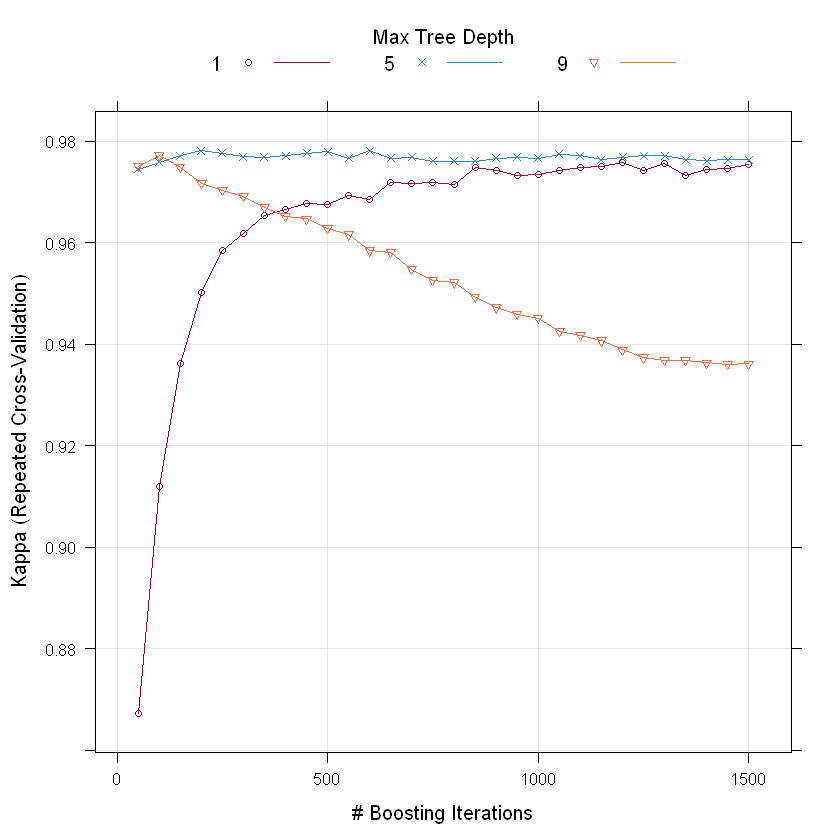

In [26]:
gbmFit1
trellis.par.set(caretTheme())
plot(gbmFit1, metric = "Kappa")

# Random Forests
library(e1071)
start.time <-Sys.time()
set.seed(2)
rf <- train(x=train[,-2],
            y=as.factor(train[,2]),
            method="rf",
            ntree=200,
           trContrl=fitControl,
           tuneGrid=rfGrid,
           importance=TRUE)
end.time<-Sys.time()
time.taken.rf <-end.time - start.time

In [22]:
head(data)

,year,Match_Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,Halftime_Home_Goals,Halftime_Away_Goals,Hometeam_Shots,Awayteam_Shots,Hometeam_Shots_Target,Awayteam_Shots_Target,Hometeam_Fouls,Awayteam_Fouls,Hometeam_Corners,Awayteam_Corners,Hometeam_Yellowcards,Awayteam_Yellowcards,Hometeam_Redcards,Awayteam_Redcards,month
1,2016,2016-04-24,EINTRACHT FRANKFURT,FSV MAINZ 05,2,1,1,1,8,7,4,4,22,23,5,2,4,4,0,0,4
2,2016,2016-04-24,BOR. MONCHENGLADBACH,1899 HOFFENHEIM,3,1,2,0,24,14,11,8,14,11,12,3,1,2,0,0,4
3,2016,2016-04-23,FC KOLN,SV DARMSTADT 98,4,1,2,1,15,15,9,2,15,17,3,6,2,2,0,0,4
4,2016,2016-04-23,HERTHA BERLIN,BAYERN MUNICH,0,2,0,0,9,6,0,6,9,17,1,3,0,4,0,0,4
5,2016,2016-04-23,FC INGOLSTADT 04,HANNOVER 96,2,2,2,0,8,14,3,4,10,13,2,7,2,2,1,0,4
6,2016,2016-04-23,FC SCHALKE 04,BAYER LEVERKUSEN,2,3,2,0,20,16,8,6,19,16,6,4,3,3,0,0,4


In [27]:
saveRDS(data[1,], "newCasegbm.rda")

In [28]:
saveRDS(data[1,], "newCase.rda")
saveRDS(data, "RWCData.rda")

In [29]:
readRDS("newCase.rda")

,Outcome,Match_Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,Halftime_Home_Goals,Halftime_Away_Goals,Hometeam_Shots,Awayteam_Shots,Hometeam_Shots_Target,Awayteam_Shots_Target,Hometeam_Fouls,Awayteam_Fouls,Hometeam_Corners,Awayteam_Corners,Hometeam_Yellowcards,Awayteam_Yellowcards,Hometeam_Redcards,Awayteam_Redcards,month,year
1,win,2016-04-24,EINTRACHT FRANKFURT,FSV MAINZ 05,2,1,1,1,8,7,4,4,22,23,5,2,4,4,0,0,4,2016


In [532]:
rf
time.taken.rf

Random Forest 

598 samples
 21 predictor
  3 classes: 'loose', 'tie', 'win' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 598, 598, 598, 598, 598, 598, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   1    0.7481162  0.5920595
   7    0.9426907  0.9109578
  14    0.9833403  0.9741127
  27    0.9836474  0.9745888
  37    0.9820680  0.9721605
  40    0.9828500  0.9733733
  53    0.9834030  0.9742631

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 27. 

Time difference of 1.075067 mins

## Creating the final model

In [30]:
# load data
data <- readRDS("RWCData.rda")
head(data)

,Outcome,Match_Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,Halftime_Home_Goals,Halftime_Away_Goals,Hometeam_Shots,Awayteam_Shots,Hometeam_Shots_Target,Awayteam_Shots_Target,Hometeam_Fouls,Awayteam_Fouls,Hometeam_Corners,Awayteam_Corners,Hometeam_Yellowcards,Awayteam_Yellowcards,Hometeam_Redcards,Awayteam_Redcards,month,year
1,win,2016-04-24,EINTRACHT FRANKFURT,FSV MAINZ 05,2,1,1,1,8,7,4,4,22,23,5,2,4,4,0,0,4,2016
2,win,2016-04-24,BOR. MONCHENGLADBACH,1899 HOFFENHEIM,3,1,2,0,24,14,11,8,14,11,12,3,1,2,0,0,4,2016
3,win,2016-04-23,FC KOLN,SV DARMSTADT 98,4,1,2,1,15,15,9,2,15,17,3,6,2,2,0,0,4,2016
4,loose,2016-04-23,HERTHA BERLIN,BAYERN MUNICH,0,2,0,0,9,6,0,6,9,17,1,3,0,4,0,0,4,2016
5,tie,2016-04-23,FC INGOLSTADT 04,HANNOVER 96,2,2,2,0,8,14,3,4,10,13,2,7,2,2,1,0,4,2016
6,loose,2016-04-23,FC SCHALKE 04,BAYER LEVERKUSEN,2,3,2,0,20,16,8,6,19,16,6,4,3,3,0,0,4,2016


### Model

#tune grid
rfGrid <- expand.grid(mtry=c(1,6,7,8,9,10,15,10,25,30,35,40,45,50))
# Tune using 5-fold cross-validation
fitControl <- trainControl(method="cv",
                          number=5,
                          repeats=1)
#Train classifier
model <- train(x=data[,-2], y=data[,2], method="rf",
               ntree=1000,
               trControl=fitControl,
               tuneGrid=rfGrid)
#save model
saveRDS(model, file="Soccer_Prediction_Model.rda")


In [106]:
#test$Outcome <- NA
test$Home_Goals <- NA
head(test)

,Outcome,Match_Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,Halftime_Home_Goals,Halftime_Away_Goals,Hometeam_Shots,Awayteam_Shots,Hometeam_Shots_Target,Awayteam_Shots_Target,Hometeam_Fouls,Awayteam_Fouls,Hometeam_Corners,Awayteam_Corners,Hometeam_Yellowcards,Awayteam_Yellowcards,Hometeam_Redcards,Awayteam_Redcards,month,year
1,win,2016-04-24,EINTRACHT FRANKFURT,FSV MAINZ 05,NA,1,1,1,8,7,4,4,22,23,5,2,4,4,0,0,4,2016
3,win,2016-04-23,FC KOLN,SV DARMSTADT 98,NA,1,2,1,15,15,9,2,15,17,3,6,2,2,0,0,4,2016
5,tie,2016-04-23,FC INGOLSTADT 04,HANNOVER 96,NA,2,2,0,8,14,3,4,10,13,2,7,2,2,1,0,4,2016
7,loose,2016-04-23,VfB STUTTGART,BORUSSIA DORTMUND,NA,3,0,2,8,16,1,9,19,10,3,4,0,1,0,0,4,2016
9,win,2016-04-22,HAMBURGER SV,WERDER BREMEN,NA,1,2,0,12,21,7,10,22,11,5,4,3,4,0,0,4,2016
11,loose,2016-04-17,FSV MAINZ 05,FC KOLN,NA,3,1,0,18,12,7,4,12,11,6,7,1,2,0,0,4,2016


In [110]:
# test gbm classifier
predict(gbmFit1, newdata=head(test), type="prob")

ERROR: Error: variable 'Home_Goals' was fitted with type "numeric" but type "logical" was supplied



## On-demand prediction

In [43]:
dim(data)
head(data)

[1] 1197   22

,Outcome,Match_Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,Halftime_Home_Goals,Halftime_Away_Goals,Hometeam_Shots,Awayteam_Shots,Hometeam_Shots_Target,Awayteam_Shots_Target,Hometeam_Fouls,Awayteam_Fouls,Hometeam_Corners,Awayteam_Corners,Hometeam_Yellowcards,Awayteam_Yellowcards,Hometeam_Redcards,Awayteam_Redcards,month,year
1,win,2016-04-24,EINTRACHT FRANKFURT,FSV MAINZ 05,2,1,1,1,8,7,4,4,22,23,5,2,4,4,0,0,4,2016
2,win,2016-04-24,BOR. MONCHENGLADBACH,1899 HOFFENHEIM,3,1,2,0,24,14,11,8,14,11,12,3,1,2,0,0,4,2016
3,win,2016-04-23,FC KOLN,SV DARMSTADT 98,4,1,2,1,15,15,9,2,15,17,3,6,2,2,0,0,4,2016
4,loose,2016-04-23,HERTHA BERLIN,BAYERN MUNICH,0,2,0,0,9,6,0,6,9,17,1,3,0,4,0,0,4,2016
5,tie,2016-04-23,FC INGOLSTADT 04,HANNOVER 96,2,2,2,0,8,14,3,4,10,13,2,7,2,2,1,0,4,2016
6,loose,2016-04-23,FC SCHALKE 04,BAYER LEVERKUSEN,2,3,2,0,20,16,8,6,19,16,6,4,3,3,0,0,4,2016


In [36]:
awayteamStats<-NULL
hometeamStats<-NULL

In [55]:
hometeamStats<- allgames[c(1,2,21,22,3,5,7,9,11,13,15,17,19)]

In [56]:
awayteamStats<- allgames[c(1,2,21,22,4,6,8,10,12,14,16,18,20)]

In [57]:
dim(awayteamStats)
head(awayteamStats)

[1] 1197   13

,Outcome,Match_Date,month,year,AwayTeam,Away_Goals,Halftime_Away_Goals,Awayteam_Shots,Awayteam_Shots_Target,Awayteam_Fouls,Awayteam_Corners,Awayteam_Yellowcards,Awayteam_Redcards
1,win,2016-04-24,4,2016,FSV MAINZ 05,1,1,7,4,23,2,4,0
2,win,2016-04-24,4,2016,1899 HOFFENHEIM,1,0,14,8,11,3,2,0
3,win,2016-04-23,4,2016,SV DARMSTADT 98,1,1,15,2,17,6,2,0
4,loose,2016-04-23,4,2016,BAYERN MUNICH,2,0,6,6,17,3,4,0
5,tie,2016-04-23,4,2016,HANNOVER 96,2,0,14,4,13,7,2,0
6,loose,2016-04-23,4,2016,BAYER LEVERKUSEN,3,0,16,6,16,4,3,0


In [58]:
# create predictors
awayteamStatsagg <- aggregate(awayteamStats[1:nrow(awayteamStats),6:13],
                              by=list(awayteamStats$AwayTeam),
                              FUN=mean)

hometeamStatsagg <- aggregate(hometeamStats[1:nrow(hometeamStats),6:13],
                              by=list(hometeamStats$HomeTeam),
                              FUN=mean)


## Final model on whole dataset

In [59]:
# Tune using 5-fold cross-validation
fitControl2 <- trainControl(method="cv",
                         number=10,
                         repeats=5)

In [102]:
# fitting gbm for "Outcome"
library(gbm)
gbmFit2 <- train(Outcome~., data=data,
                method="gbm",
                trControl = fitControl2,
                verbose=FALSE,
                tuneGrid = gbmGrid)

# Create function to take team name inputs and return a prediction, RF version
predict_match <- function(homeTeam,awayTeam){
    date<-Sys.Date()
    #newCase<-matrix(nrow = 1, ncol = 22)
    newCase<-readRDS("newCase.rda")
    newCase[1,1]<-factor(year(date))
    newCase[1,2]<-"tie"
    newCase[1,3]<-date
    newCase[1,4]<-homeTeam
    newCase[1,5]<-awayTeam
    newCase[1,c(7,9,11,13,15,17,19,21)]<-awayteamStatsagg[awayteamStatsagg[1] == awayTeam][2:9]
    newCase[1,c(6,8,10,12,14,16,18,20)]<-hometeamStatsagg[hometeamStatsagg[1] == homeTeam][2:9]
    newCase[1,22]<-factor(month(date))
    #return(head(newCase))
    y_probs1 <- predict.train(model, newCase)
    y_probs2 <- predict.train(model, newCase)
    return(y_probs1)
        xlooseProb <- round((y_probs1[1] + y_probs2[2])/3)
        xwinProb <- round((y_probs1[2] + y_probs2[1])/3)
        xreturn(as.character(c(looseProb, winProb)))
}

In [61]:
head(hometeamStatsagg)

,Group.1,Home_Goals,Halftime_Home_Goals,Hometeam_Shots,Hometeam_Shots_Target,Hometeam_Fouls,Hometeam_Corners,Hometeam_Yellowcards,Hometeam_Redcards
1,FSV MAINZ 05,1.515152,0.6969697,12.93939,4.30303,14.87879,4.515152,1.590909,0.09090909
2,SV DARMSTADT 98,0.9333333,0.4666667,9.466667,3.2,15.4,3.4,2.6,0
3,1899 HOFFENHEIM,1.727273,0.8787879,14.56061,5.454545,16.24242,4.636364,1.757576,0.09090909
4,BAYER LEVERKUSEN,2.060606,0.8484848,17.25758,6.348485,15.10606,6.742424,1.833333,0.07575758
5,BAYERN MUNICH,2.984848,1.287879,19.87879,8.69697,11.31818,8.363636,1.015152,0.04545455
6,BOR. MONCHENGLADBACH,2.044776,0.9253731,13.79104,5.820896,12.1791,4.537313,1.41791,0.07462687


In [63]:
head(awayteamStatsagg)

,Group.1,Away_Goals,Halftime_Away_Goals,Awayteam_Shots,Awayteam_Shots_Target,Awayteam_Fouls,Awayteam_Corners,Awayteam_Yellowcards,Awayteam_Redcards
1,FSV MAINZ 05,1.223881,0.5970149,10.91045,4.044776,14.95522,3.731343,1.761194,0.07462687
2,SV DARMSTADT 98,1.3125,0.875,11.0625,3.6875,17.4375,3.625,2.5625,0
3,1899 HOFFENHEIM,1.268657,0.5820896,11.71642,4.208955,17.62687,3.716418,2.029851,0.08955224
4,BAYER LEVERKUSEN,1.507463,0.7014925,13.50746,5.059701,16.76119,5.41791,2.179104,0.1044776
5,BAYERN MUNICH,2.223881,0.8507463,15.59701,6.149254,12.8209,5.61194,1.328358,0.04477612
6,BOR. MONCHENGLADBACH,1.242424,0.5606061,10.51515,3.909091,12.65152,4.106061,1.636364,0.06060606


In [64]:
dim(readRDS("newCasegbm.rda"))

[1]  1 22

In [78]:
head(readRDS("newCasegbm.rda"))

,Outcome,Match_Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,Halftime_Home_Goals,Halftime_Away_Goals,Hometeam_Shots,Awayteam_Shots,Hometeam_Shots_Target,Awayteam_Shots_Target,Hometeam_Fouls,Awayteam_Fouls,Hometeam_Corners,Awayteam_Corners,Hometeam_Yellowcards,Awayteam_Yellowcards,Hometeam_Redcards,Awayteam_Redcards,month,year
1,win,2016-04-24,EINTRACHT FRANKFURT,FSV MAINZ 05,2,1,1,1,8,7,4,4,22,23,5,2,4,4,0,0,4,2016


In [157]:
# Create function to take team name inputs and return a prediction, gbm version
predict_match <- function(homeTeam,awayTeam){
    date<-Sys.Date()
    
    #build new case
    newCase<-readRDS("newCasegbm.rda")
    newCase$Halftime_Result <- NULL
    newCase[1,1]<-NA
    newCase[1,2]<-factor(date)
    newCase[1,22]<-factor(year(date))
    newCase[1,21]<-factor(month(date))
    newCase[1,3]<-homeTeam
    newCase[1,4]<-awayTeam
    #calculate aggregation for current season
    awayteamStatsagg <- aggregate(subset(awayteamStats,year==year(date))[1:nrow(subset(awayteamStats,year==year(date))),6:13],
                             by=list(subset(awayteamStats$AwayTeam,year==year(date))), FUN=mean)

    hometeamStatsagg <- aggregate(subset(hometeamStats,year==year(date))[1:nrow(subset(hometeamStats,year==year(date))),6:13],
                             by=list(subset(hometeamStats$HomeTeam,year==year(date))), FUN=mean)
    
    newCase[1,c(6,8,10,12,14,16,18,20)]<-ceiling(as.numeric(awayteamStatsagg[awayteamStatsagg[1] == awayTeam][2:9]))
    newCase[1,c(5,7,9,11,13,15,17,19)]<-floor(as.numeric(hometeamStatsagg[hometeamStatsagg[1] == homeTeam][2:9]))
    
    #return(newCase)
    # predict prob of new case
    #newCase[1,6:20]<-as.numeric(newCase[1,5:20])
    
    #return(head(newCase))
    y_probs <- predict(gbmFit2, newdata=newCase, type="prob")
    print(y_probs)
    return((newCase))
    #return(y_probs)
}

In [161]:
predict_match(homeTeam,awayTeam)

       loose       tie        win
1 0.02258111 0.9575267 0.01989216


,Outcome,Match_Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,Halftime_Home_Goals,Halftime_Away_Goals,Hometeam_Shots,Awayteam_Shots,Hometeam_Shots_Target,Awayteam_Shots_Target,Hometeam_Fouls,Awayteam_Fouls,Hometeam_Corners,Awayteam_Corners,Hometeam_Yellowcards,Awayteam_Yellowcards,Hometeam_Redcards,Awayteam_Redcards,month,year
1,NA,2016-05-01,SV DARMSTADT 98,EINTRACHT FRANKFURT,1,1,0,1,9,10,4,4,15,17,3,3,2,4,0,0,5,2016


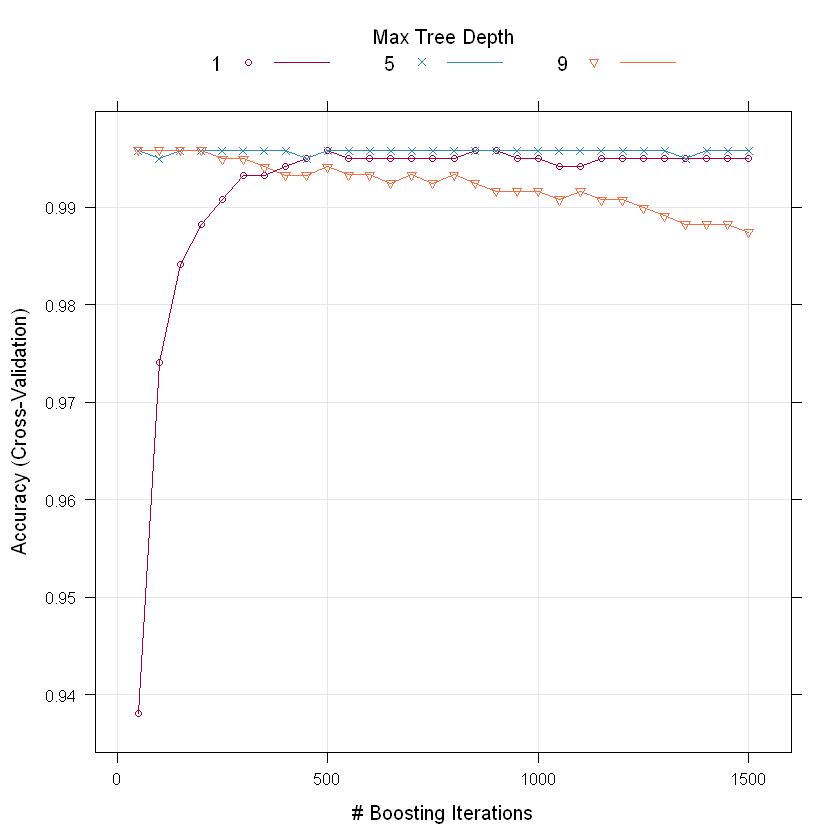

In [155]:
plot(gbmFit2)

In [163]:
homeTeam<-"WERDER BREMEN"
awayTeam<-"VfB STUTTGART"
predict_match(homeTeam,awayTeam)

       loose      tie        win
1 0.03340544 0.930872 0.03572253


,Outcome,Match_Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,Halftime_Home_Goals,Halftime_Away_Goals,Hometeam_Shots,Awayteam_Shots,Hometeam_Shots_Target,Awayteam_Shots_Target,Hometeam_Fouls,Awayteam_Fouls,Hometeam_Corners,Awayteam_Corners,Hometeam_Yellowcards,Awayteam_Yellowcards,Hometeam_Redcards,Awayteam_Redcards,month,year
1,NA,2016-05-01,WERDER BREMEN,VfB STUTTGART,2,2,1,1,16,14,6,6,15,16,5,7,2,2,0,1,5,2016


In [94]:
awayteamStatsagg$Group.1

[1]  FSV MAINZ 05         SV DARMSTADT 98     1899 HOFFENHEIM     
 [4] BAYER LEVERKUSEN     BAYERN MUNICH        BOR. MONCHENGLADBACH
 [7] BORUSSIA DORTMUND    Braunschweig         EINTRACHT FRANKFURT 
[10] FC AUGSBURG          FC INGOLSTADT 04     FC KOLN             
[13] FC SCHALKE 04        Fortuna Dusseldorf   Freiburg            
[16] Greuther Furth       HAMBURGER SV         HANNOVER 96         
[19] HERTHA BERLIN        Nurnberg             Paderborn           
[22] VfB STUTTGART        VfL WOLFSBURG        WERDER BREMEN       
24 Levels:  FSV MAINZ 05  SV DARMSTADT 98 1899 HOFFENHEIM ... WERDER BREMEN

In [483]:
year = year(Match_Date)
Outcome = "tie"
Match_Date = Sys.Date()
HomeTeam = factor("FC AUGSBURG")
AwayTeam = factor("FC KOLN")
Home_Goals = 0
Away_Goals = 0
Halftime_Home_Goals = 0
Halftime_Away_Goals = 0
Hometeam_Shots = 8
Awayteam_Shots = 5
Hometeam_Shots_Target = 1
Awayteam_Shots_Target = 0
Hometeam_Fouls = 10
Awayteam_Fouls = 14
Hometeam_Corners = 5
Awayteam_Corners = 5
Hometeam_Yellowcards = 3
Awayteam_Yellowcards = 3
Hometeam_Redcards = 0
Awayteam_Redcards = 1
month = month(Match_Date)


In [487]:
newrow<- data.frame(year, Outcome, Match_Date, HomeTeam, AwayTeam, Home_Goals, Away_Goals, Halftime_Home_Goals, Halftime_Away_Goals, Hometeam_Shots, Awayteam_Shots, Hometeam_Shots_Target, Awayteam_Shots_Target, Hometeam_Fouls, Awayteam_Fouls, Hometeam_Corners, Awayteam_Corners, Hometeam_Yellowcards, Awayteam_Yellowcards, Hometeam_Redcards, Awayteam_Redcards, month)

In [488]:
str(newrow)

'data.frame':	1 obs. of  22 variables:
 $ year                 : num 2016
 $ Outcome              : Factor w/ 1 level "tie": 1
 $ Match_Date           : Date, format: "2016-05-01"
 $ HomeTeam             : Factor w/ 1 level "FC AUGSBURG": 1
 $ AwayTeam             : Factor w/ 1 level "FC KOLN": 1
 $ Home_Goals           : num 0
 $ Away_Goals           : num 0
 $ Halftime_Home_Goals  : num 0
 $ Halftime_Away_Goals  : num 0
 $ Hometeam_Shots       : num 8
 $ Awayteam_Shots       : num 5
 $ Hometeam_Shots_Target: num 1
 $ Awayteam_Shots_Target: num 0
 $ Hometeam_Fouls       : num 10
 $ Awayteam_Fouls       : num 14
 $ Hometeam_Corners     : num 5
 $ Awayteam_Corners     : num 5
 $ Hometeam_Yellowcards : num 3
 $ Awayteam_Yellowcards : num 3
 $ Hometeam_Redcards    : num 0
 $ Awayteam_Redcards    : num 1
 $ month                : num 5


In [494]:
temp = rbind(data,newrow)

In [495]:
str(data)

'data.frame':	1197 obs. of  22 variables:
 $ year                 : Factor w/ 5 levels "2012","2013",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Outcome              : Factor w/ 3 levels "loose","tie",..: 3 3 3 1 2 1 1 1 3 3 ...
 $ Match_Date           : Date, format: "2016-04-24" "2016-04-24" ...
 $ HomeTeam             : Factor w/ 24 levels " FSV MAINZ 05",..: 9 6 12 19 11 13 22 23 17 7 ...
 $ AwayTeam             : Factor w/ 24 levels " FSV MAINZ 05",..: 1 3 2 5 18 4 7 10 24 17 ...
 $ Home_Goals           : num  2 3 4 0 2 2 0 0 2 3 ...
 $ Away_Goals           : num  1 1 1 2 2 3 3 2 1 0 ...
 $ Halftime_Home_Goals  : num  1 2 2 0 2 2 0 0 2 2 ...
 $ Halftime_Away_Goals  : num  1 0 1 0 0 0 2 1 0 0 ...
 $ Hometeam_Shots       : num  8 24 15 9 8 20 8 19 12 14 ...
 $ Awayteam_Shots       : num  7 14 15 6 14 16 16 8 21 5 ...
 $ Hometeam_Shots_Target: num  4 11 9 0 3 8 1 7 7 5 ...
 $ Awayteam_Shots_Target: num  4 8 2 6 4 6 9 4 10 1 ...
 $ Hometeam_Fouls       : num  22 14 15 9 10 19 19 7 22 6 ...
 $ Away